<a href="https://colab.research.google.com/github/deltorobarba/sciences/blob/master/galaxy_M51.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Galaxy M51 (Whirpool)**

[M51 (Whirlpool Galaxy)](https://en.m.wikipedia.org/wiki/Whirlpool_Galaxy) an interacting spiral galaxy with a Seyfert 2 active galactic nucleus at 23 mio light years distance

![sciences](https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Messier51_sRGB.jpg/640px-Messier51_sRGB.jpg)

*Whirlpool Galaxy (M51a), as taken by the European Space Agency, the smaller object in the upper right is NGC 5195 (M51b)
(NASA/ESA)*

In [ ]:
!pip install astropy astroquery reproject -q
from astroquery.ipac.irsa import Irsa
from astropy import units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy import coordinates
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from reproject import reproject_interp
import numpy as np
import astropy.units as u
%matplotlib inline

#### *Define object and get skycoordinates*

In [ ]:
# Define object (Galaxy name)
object_name = 'M 51'

In [ ]:
# Get and set skycoordinates of object
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord

skyobject = Simbad.query_object(object_name)
ra_hms = skyobject['RA'][0]
dec_dms = skyobject['DEC'][0]
coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
print(skyobject)
print("\nCoordinates:")
print("RA (h:m:s):", ra_hms)
print("DEC (d:m:s):", dec_dms)

MAIN_ID      RA          DEC      RA_PREC ... COO_WAVELENGTH     COO_BIBCODE     SCRIPT_NUMBER_ID
          "h:m:s"      "d:m:s"            ...                                                    
------- ------------ ------------ ------- ... -------------- ------------------- ----------------
  M  51 13 29 52.698 +47 11 42.93       7 ...              I 2006AJ....131.1163S                1

Coordinates:
RA (h:m:s): 13 29 52.698
DEC (d:m:s): +47 11 42.93


#### *Create composite, multi-wavelengths images from MAST*

In [ ]:
# Code for Multi-Wavelength Composite (with MAST)

from astroquery.mast import Observations
from astropy.visualization import make_lupton_rgb

# Function to create composite image
def process_hst_images(params):
    # Search for observations
    obs_table = Observations.query_region(params.coords, radius=params.search_radius)

    # Filter for HST observations with specific filters
    hst_obs = obs_table[obs_table['instrument_name'] == params.instrument]

    # Get observations for each filter
    filter_data = {}
    for color, filter_name in params.rgb_filters.items():
        filter_data[color] = hst_obs[hst_obs['filters'] == filter_name]
        print(f"{filter_name}: {len(filter_data[color])} observations")

    # Check if we have all required filters
    if all(len(data) > 0 for data in filter_data.values()):
        print("\nDownloading data products...")

        # Download and process each filter
        hdus = {}
        for color, observations in filter_data.items():
            products = Observations.get_product_list(observations[0]['obsid'])
            files = Observations.download_products(products[products['productSubGroupDescription'] == 'DRZ'])
            hdus[color] = fits.open(files['Local Path'][0])[1]

        # Reproject images to match the red channel
        print("Aligning images...")
        aligned_data = {
            'red': hdus['red'].data,
            'green': reproject_interp(hdus['green'], hdus['red'].header)[0],
            'blue': reproject_interp(hdus['blue'], hdus['red'].header)[0]
        }

        # Normalize the data
        print("Normalizing data...")
        normalized_data = {color: normalize(data) for color, data in aligned_data.items()}

        # Create RGB image
        print("Creating color composite...")
        rgb = make_lupton_rgb(
            normalized_data['red'],
            normalized_data['green'],
            normalized_data['blue'],
            Q=params.rgb_params['Q'],
            stretch=params.rgb_params['stretch']
        )

        # Plot
        plt.figure(figsize=params.figure_size)
        plt.imshow(rgb, origin='lower')
        plt.title(f'{params.object_name} - HST {params.instrument} Composite')
        plt.axis('off')
        plt.show()
    else:
        print("Could not find all required filter observations")

def normalize(arr):
    """Normalize array data"""
    arr = np.nan_to_num(arr, 0)  # Replace NaN with 0
    return arr / np.percentile(arr[arr > 0], 99)

In [ ]:
# Filter combinations for Object (HST observations)
from astroquery.mast import Observations
import astropy.units as u
from astropy.coordinates import SkyCoord

# coords = coord # SkyCoord('13h29m52.7s +47d11m43s', unit=(u.hourangle, u.deg)) # e.g. for M51
# Search for observations
obs_table = Observations.query_region(coord, radius=0.2 * u.deg)

# Get unique combinations of instruments and filters
hst_obs = obs_table[obs_table['obs_collection'] == 'HST']
unique_filters = {}

for obs in hst_obs:
    instrument = obs['instrument_name']
    filt = obs['filters']
    if instrument not in unique_filters:
        unique_filters[instrument] = set()
    if filt:  # Some observations might not have filter info
        unique_filters[instrument].add(filt)

# Print available filters by instrument
for instrument, filters in unique_filters.items():
    print(f"\n{instrument} filters:")
    for f in sorted(filters):
        print(f"  - {f}")


ACS/WFC filters:
  - F330W
  - F435W
  - F502N
  - F555W
  - F606W
  - F658N
  - F660N
  - F775W
  - F814W
  - detection

WFPC2/PC filters:
  - F160BW
  - F218W
  - F255W
  - F300W
  - F336W
  - F439W
  - F450W
  - F502N
  - F547M
  - F555W
  - F606W
  - F656N
  - F675W
  - F814W
  - detection

WFC3/IR filters:
  - BLANK
  - F105W
  - F110W
  - F125W
  - F128N
  - F140W
  - F153M
  - F160W
  - detection

WFC3/UVIS filters:
  - F225W
  - F275W
  - F280N
  - F336W
  - F343N
  - F373N
  - F390M
  - F438W
  - F467M
  - F475W
  - F475X
  - F487N
  - F502N
  - F547M
  - F555W
  - F606W
  - F631N
  - F657N
  - F673N
  - F689M
  - F814W
  - F845M
  - detection

ACS/HRC filters:
  - F220W
  - F250W
  - F330W
  - F555W
  - F775W;CLEAR2L
  - F775W;F330W
  - F814W
  - PR200L
  - detection

STIS filters:
  - G230LB
  - G430L
  - G430L;G430M;G750L
  - G430L;G750M
  - G750M

NICMOS/NIC2 filters:
  - BLANK
  - F110W
  - F160W
  - F187N
  - F190N
  - F205W
  - F212N
  - F215N
  - F216N
  - F222M

NICM

**Image using ACF/WFC instruments**

F435W: 107 observations
F555W: 80 observations
F814W: 171 observations



INFO:astroquery:Found cached file ./mastDownload/HST/j97c31rrq/j97c31rrq_drz.fits with expected size 214447680.


INFO: Found cached file ./mastDownload/HST/j97c31rrq/j97c31rrq_drz.fits with expected size 214447680. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HST/j97c31rsq/j97c31rsq_drz.fits with expected size 214395840.


INFO: Found cached file ./mastDownload/HST/j97c31rsq/j97c31rsq_drz.fits with expected size 214395840. [astroquery.query]


INFO:astroquery:Found cached file ./mastDownload/HST/j97c31ruq/j97c31ruq_drz.fits with expected size 214344000.


INFO: Found cached file ./mastDownload/HST/j97c31ruq/j97c31ruq_drz.fits with expected size 214344000. [astroquery.query]
Aligning images...
Normalizing data...
Creating color composite...


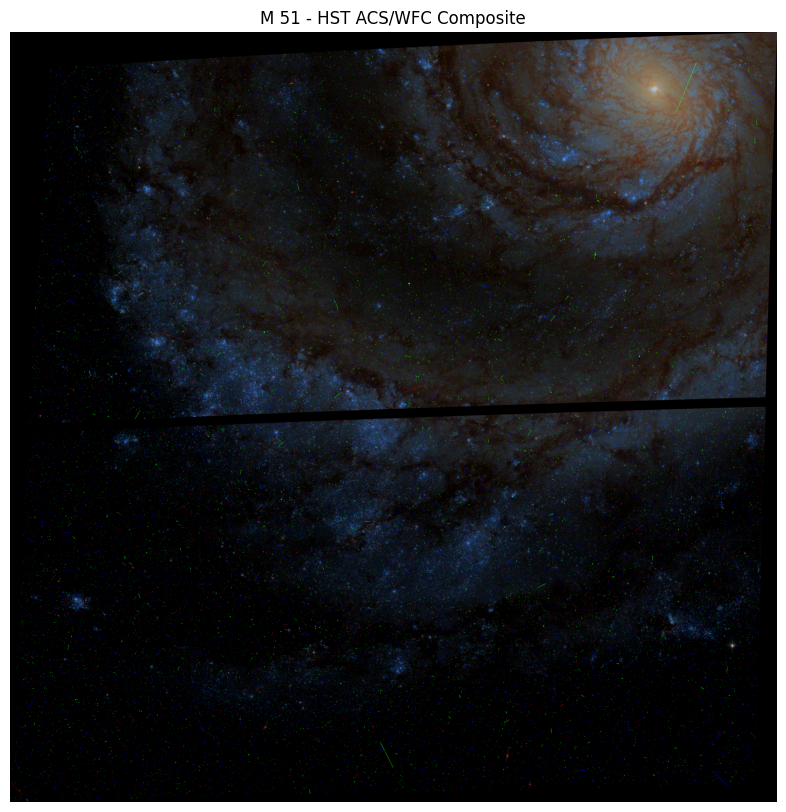

In [ ]:
# Create composite image of astronomical objects automatically
# ('object_name' and 'coord' are defined in the beginning, 'rgb_filters' and 'instrument' above)

class ObservationParams:
    def __init__(self):
        # Target coordinates
        self.coords = coord
        self.search_radius = 0.2 * u.deg

        # RGB filter configuration
        self.rgb_filters = {
            'blue': 'F435W',
            'green': 'F555W',
            'red': 'F814W'
        }

        # Instrument configuration
        self.instrument = 'ACS/WFC'

        # Image processing parameters
        self.rgb_params = {
            'Q': 10,
            'stretch': 0.5
        }

        # Visualization parameters
        self.figure_size = (10, 10)
        self.object_name = object_name

# Execute image processing
params = ObservationParams()
process_hst_images(params)

**Image using WFC3/UVIS instruments**

F275W: 36 observations
F606W: 77 observations
F814W: 15 observations

Aligning images...
Normalizing data...
Creating color composite...


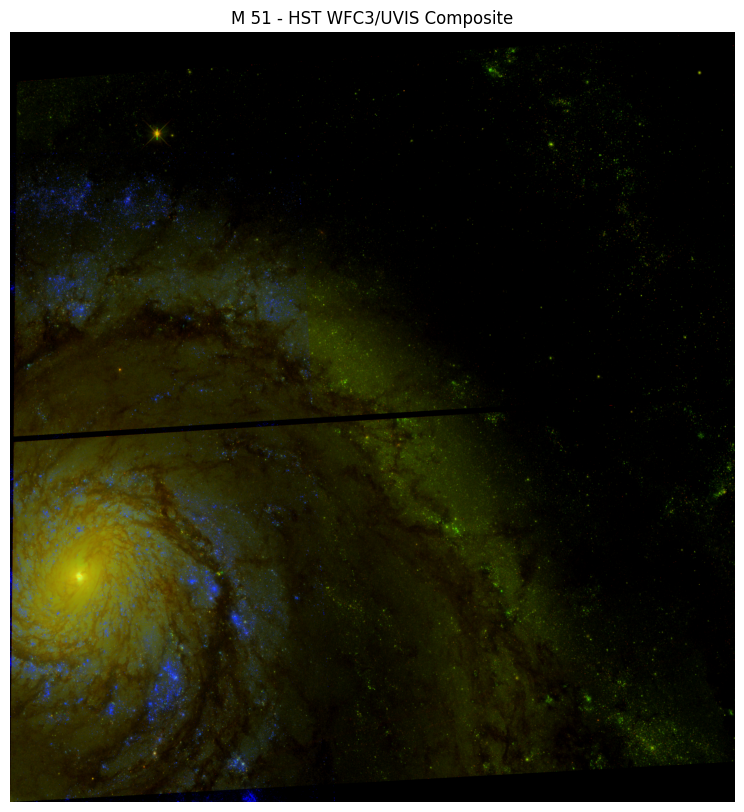

In [ ]:
# Create composite image of astronomical objects automatically
# ('object_name' and 'coord' are defined in the beginning, 'rgb_filters' and 'instrument' above)

class ObservationParams:
    def __init__(self):
        # Target coordinates
        self.coords = coord
        self.search_radius = 0.2 * u.deg

        # RGB filter configuration
        self.rgb_filters = {
            'blue': 'F275W',
            'green': 'F606W',
            'red': 'F814W'
        }

        # Instrument configuration
        self.instrument = 'WFC3/UVIS'

        # Image processing parameters
        self.rgb_params = {
            'Q': 10,
            'stretch': 0.5
        }

        # Visualization parameters
        self.figure_size = (10, 10)
        self.object_name = object_name

# Execute image processing
params = ObservationParams()
process_hst_images(params)

#### *Pull infrared images from IRSA*

In [ ]:
# Select collection (images)
collection = 'spitzer_seip'

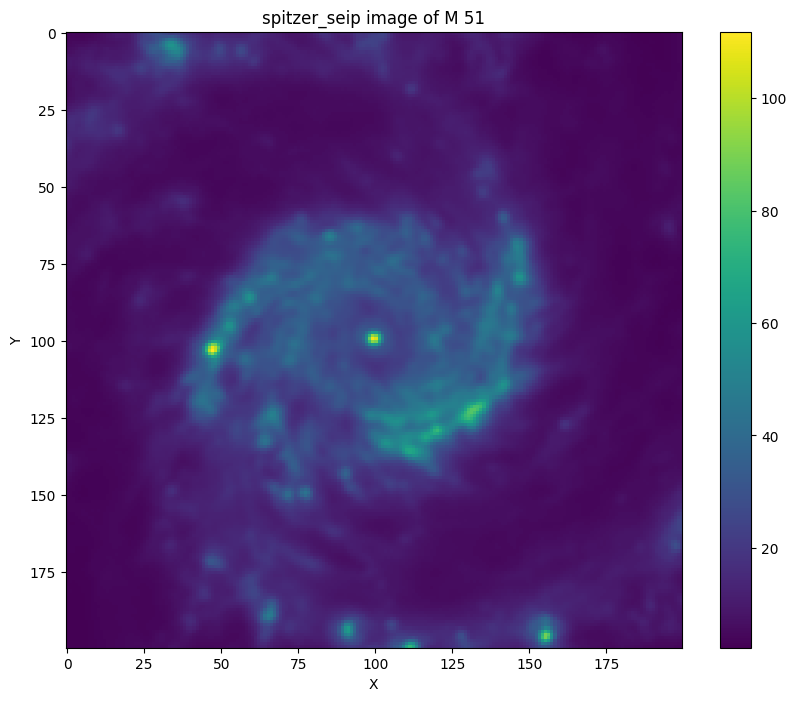

(<matplotlib.image.AxesImage at 0x7d4a5641ad10>,
 None)

In [ ]:
# Simple image access queries from IRSA for galaxy images from Spitzer telescope

#coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][5]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8)).add_subplot().set(title=f'{collection} image of {object_name}', xlabel='X', ylabel='Y')
plt.imshow(cutout.data, cmap='viridis'), plt.colorbar(), plt.show()

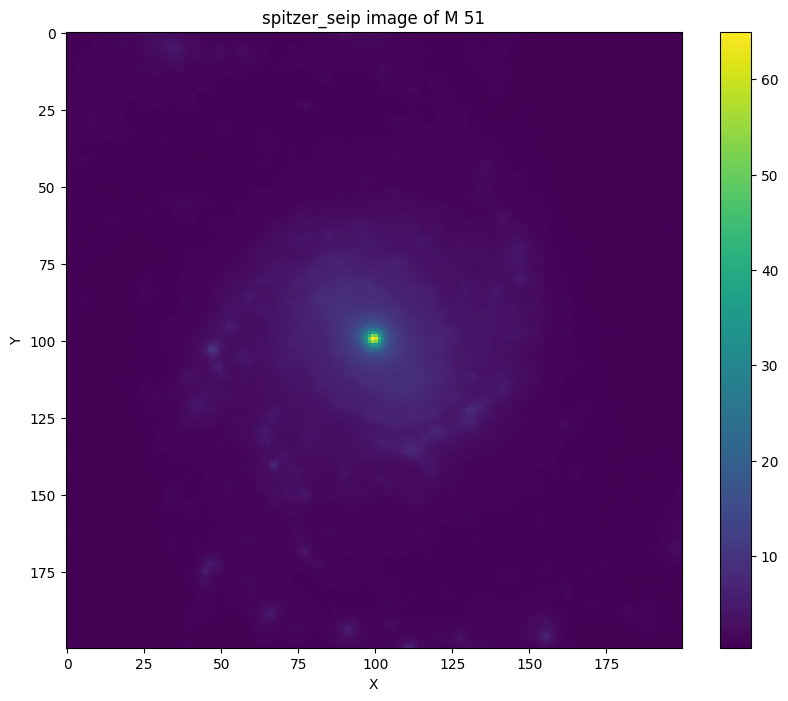

(<matplotlib.image.AxesImage at 0x7d3ea2834700>,
 None)

In [ ]:
# Simple image access queries from IRSA for galaxy images from Spitzer telescope

#coord = SkyCoord(ra=ra_hms, dec=dec_dms, unit=('hourangle', 'deg'), frame='icrs')
spitzer_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()

# Open a cutout image for one of the science images
science_image = spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'][4]
with fits.open(science_image['access_url'], use_fsspec=True) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))

plt.figure(figsize=(10, 8)).add_subplot().set(title=f'{collection} image of {object_name}', xlabel='X', ylabel='Y')
plt.imshow(cutout.data, cmap='viridis'), plt.colorbar(), plt.show()

In [ ]:
# How many science picture are therein spitzer_images?
science_images_count = len(spitzer_images[spitzer_images['dataproduct_subtype'] == 'science'])
print("Number of science images:", science_images_count)

Number of science images: 24


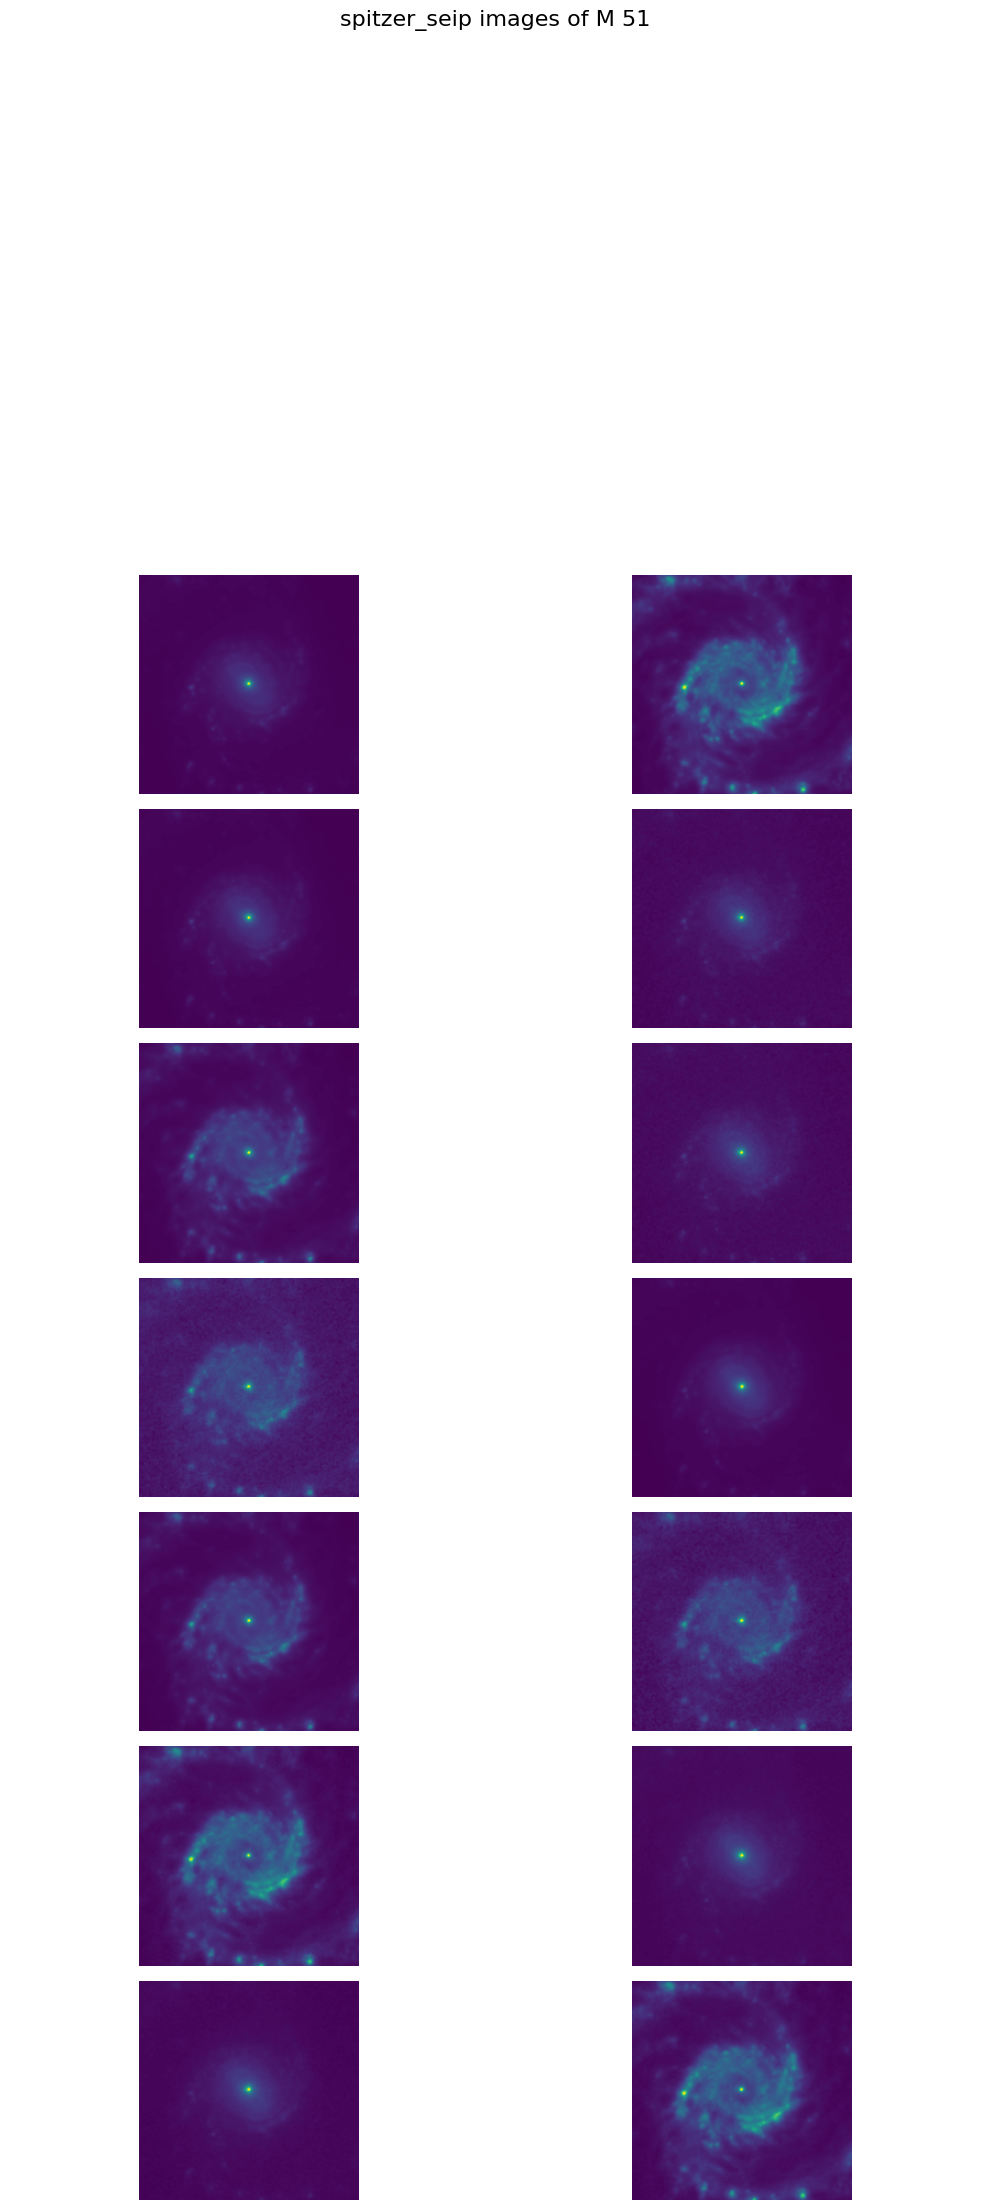

In [ ]:
# Simple image access queries from IRSA for object images from telescope
irsa_images = Irsa.query_sia(pos=(coord, 1 * u.arcmin), collection=collection).to_table()
irsa_images = irsa_images[irsa_images['dataproduct_subtype'] == 'science'] # Filter science images only

# Limit to a max number of images
max_images = 18
irsa_images_count = min(len(irsa_images), max_images)

# Set up the figure for a grid (2 images per row, total number of images/2 rows)
n_rows = (irsa_images_count + 1) // 2  # Using ceiling division to handle odd numbers
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 2.5 * n_rows))

# Loop through each of the science images
for i in range(irsa_images_count):
    # Access each science image URL
    irsa_image = irsa_images[i]
    with fits.open(irsa_image['access_url'], use_fsspec=True) as hdul:
        cutout = Cutout2D(hdul[0].section, position=coord, size=2 * u.arcmin, wcs=WCS(hdul[0].header))
        # Plot the cutout in the grid
        ax = axes[i // 2, i % 2]  # Calculate row and column for 2 images per row
        ax.imshow(cutout.data, cmap='viridis')
        ax.axis('off')  # Hide axes for clarity

# Hide empty subplots if odd number of images
if irsa_images_count % 2:
    axes[-1, -1].axis('off')

plt.suptitle(f'{collection} images of {object_name}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.show()

#### *SDSS data*

In [ ]:
# Check data availability
from astroquery.sdss import SDSS
sdss_table = SDSS.query_region(coord, radius=2*u.arcmin) # broaden radius with radius=2*u.arcmin
print(sdss_table)

       ra              dec               objid        run  rerun camcol field
---------------- ---------------- ------------------- ---- ----- ------ -----
202.423565762729 47.1979135351773 1237661362908561423 3699   301      6   100
202.423570475396 47.1979195927486 1237661362908561450 3699   301      6   100
202.480544159544 47.1679843989206 1237661362908561426 3699   301      6   100
202.480590655247 47.1680197298315 1237661362908561456 3699   301      6   100
202.461073278613  47.227999712693 1237661362908561494 3699   301      6   100
202.441757443327 47.1799740591076 1237661362908561434 3699   301      6   100
202.441759712355 47.1799738120971 1237661362908561447 3699   301      6   100
202.441755976299 47.1799748684403 1237661362908561448 3699   301      6   100
202.460860923008 47.2123789188673 1237661362908561437 3699   301      6   100
 202.46070077128 47.2124254009397 1237661362908561478 3699   301      6   100
             ...              ...                 ...  ...   ...

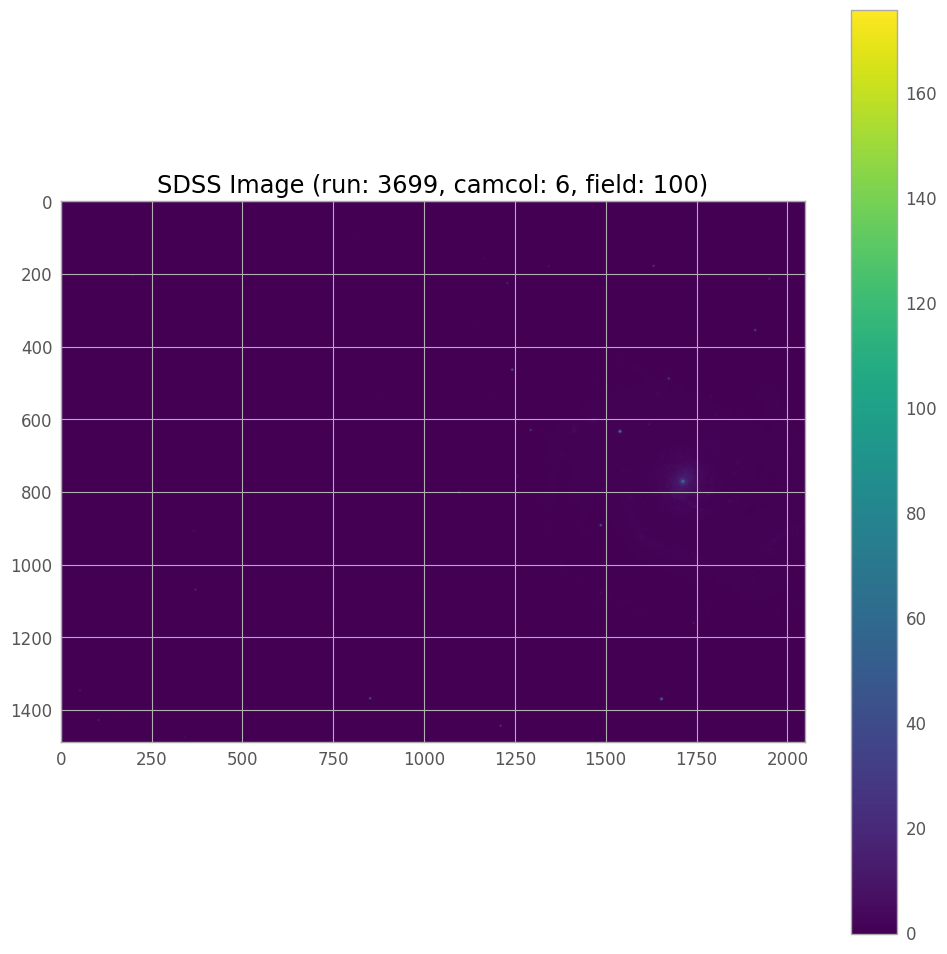

In [ ]:
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

# Define the SDSS parameters from the result table (example)
run = 3699
rerun = 301
camcol = 6
field = 100

# Query the image using the specific SDSS parameters
try:
    images = SDSS.get_images(run=run, rerun=rerun, camcol=camcol, field=field, band='r')

    # Display the first image result
    for image in images:
        plt.figure(figsize=(12, 12))
        plt.imshow(image[0].data, cmap='viridis')
        plt.colorbar()
        plt.title(f'SDSS Image (run: {run}, camcol: {camcol}, field: {field})')
        plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

#### *Get more details about the FITS file*

In [ ]:
hdul = fits.open(science_image['access_url'], use_fsspec=True)

In [ ]:
# Print the file information
hdul.info()

Filename: <class 'fsspec.implementations.http.HTTPFile'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      77   (4597, 6573)   float32   


In [ ]:
#  Access the primary HDU (Header/Data Unit) to get the data
primary_hdu = hdul[0]
data = primary_hdu.data
print(primary_hdu.header) # Display the header to learn more about the file
print(repr(hdul[0].header))  # Science data HDU header

SIMPLE  =                    T / Fits standard                                  BITPIX  =                  -32 / Bits per pixel - floating point                NAXIS   =                    2 / Number of axes                                 NAXIS1  =                 4597 / X axis length                                  NAXIS2  =                 6573 / Y axis length                                  ORIGIN  = 'Spitzer Super-Mosaic Pipeline' / Origin of these image data          CREATOR = 'Spitzer Science Center' / Creator of this FITS file                                                                                                            / TIME AND EXPOSURE INFORMATION                                                                                                                       TELESCOP= 'Spitzer '           / Name of Telescope                              INSTRUME= 'IRAC    '           / Name of Instrument                             CHNLNUM =                    2 / Instrum

In [ ]:
# Close the FITS file
hdul.close()